In [1]:
# Load packages
from matplotlib import pyplot as plt
import sys
import csv
from os import listdir
from os.path import isfile, join
from collections import defaultdict
import networkx as nx

import requests
import json
import time

import lucem_illud_2020
import pandas as pd
import numpy as np

from pushshift_py import PushshiftAPI
import datetime as dt

import sklearn
import sklearn.metrics.pairwise
import sklearn.feature_extraction.text
import sklearn.cluster
import sklearn.decomposition
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from pyanno.measures import cohens_kappa
from sklearn.inspection import permutation_importance
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib
import matplotlib.pyplot as plt
import wordcloud
import gensim
import nltk
from collections import defaultdict
import math
import re
import textstat
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [258]:
def remove_url(comment):
    s =' '.join([s for s in nltk.tokenize.casual_tokenize(comment)if 'http' not in s])
    return s

def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and not token.like_url and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized
#commentDF['body'][commentDF.body.str.contains('http')]
#print(commentDF['body'][12])
#word_tokenize(commentDF['body'][12])

In [260]:
file = "comment_listentothis_2013.csv"
commentDF = pd.read_csv(corpus_name + "/" + file)
print(commentDF.shape[0])
commentDF = commentDF[commentDF.author_flair_text != 'robot']
print(commentDF.shape[0])
commentDF = commentDF[commentDF.author != "AutoModerator"]
print(commentDF.shape[0])
commentDF = commentDF[commentDF['body'].str.contains('deleted')==False]
print(commentDF.shape[0])
commentDF['tokenized_sents'] = commentDF['body'].apply(lambda x: [lucem_illud_2020.word_tokenize(remove_url(s)) for s in lucem_illud_2020.sent_tokenize(x)])

97980
87839
72189
65702


In [282]:
# Try: 2013
file = "comment_listentothis_2013.csv"
corpus_name = "/Users/Nancy/Desktop/2020 Spring/Textual Analysis/Project/data/bigquery/comment"
commentDF = pd.read_csv(corpus_name + "/" + file)
commentDF = commentDF[commentDF.author_flair_text != 'robot']
commentDF = commentDF[commentDF.author != "AutoModerator"]
commentDF = commentDF[commentDF['body'].str.contains('deleted')==False]
# get date info
earliest = dt.datetime.fromtimestamp(min(commentDF.created_utc)).strftime("%y-%m-%d")
latest = dt.datetime.fromtimestamp(max(commentDF.created_utc)).strftime("%y-%m-%d")
print(file, earliest, latest, commentDF.shape[0])

commentDF = commentDF[['author', 'name', 'body', 'controversiality', 'created_utc', 
    'distinguished',  'gilded', 'id', 'link_id', 'parent_id', 'retrieved_on', 'score', 'score_hidden']]
print('Tokenizing:')
commentDF['tokenized_sents'] = commentDF['body'].apply(lambda x: [lucem_illud_2020.word_tokenize(remove_url(s)) for s in lucem_illud_2020.sent_tokenize(x)])
print('Normalizing:')
commentDF['normalized_sents'] = commentDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
commentDF.to_csv("../Project/Data/processed/processed_"+ file, index=False)
commentDF.head()

comment_listentothis_2013.csv 12-12-31 13-12-31 65702
Tokenizing:
Normalizing:


,author,name,body,controversiality,created_utc,distinguished,gilded,id,link_id,parent_id,retrieved_on,score,score_hidden,tokenized_sents,normalized_sents
0,fght,t1_caedexf,"Remarkable talent, even if I don't like her st...",0,1370644217,NaN,0,caedexf,t3_1fvbma,t3_1fvbma,1430888172,14,False,"[[Remarkable, talent, even, if, I, do, n't, li...","[[remarkable, talent, like, style, music]]"
2,Pleasure_Boat,t1_cafe9zz,"This is ridiculous, trying to hard Church. Con...",0,1370806052,NaN,0,cafe9zz,t3_1fzbv5,t3_1fzbv5,1430870415,-5,False,"[[This, is, ridiculous, trying, to, hard, Chur...","[[ridiculous, trying, hard, church], [convolut..."
3,prince_of_tacoma,t1_cafgcag,It's not a particularly good use of vocoder. F...,0,1370812280,NaN,0,cafgcag,t3_1fzbv5,t1_cafa8z1,1430869441,17,False,"[[It, 's, not, a, particularly, good, use, of,...","[[particularly, good, use, vocoder], [far, wet..."
4,Smackdownfletch,t1_cc4zs8s,This new album and Deltron Event II are like t...,0,1378757577,NaN,0,cc4zs8s,t3_1m1aap,t3_1m1aap,1429534603,17,False,"[[This, new, album, and, Deltron, Event, II, a...","[[new, album, deltron, event, ii, like, duke, ..."
5,geneusutwerk,t1_ce1q0iw,This album is absolutely fantastic. I highly r...,0,1387051218,NaN,0,ce1q0iw,t3_1svjka,t3_1svjka,1428133896,17,False,"[[This, album, is, absolutely, fantastic], [I,...","[[album, absolutely, fantastic], [highly, reco..."


In [264]:
corpus_name = "/Users/Nancy/Desktop/2020 Spring/Textual Analysis/Project/data/bigquery/comment"
def tokenize_normalize(corpus_name):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if "2013" not in file:
            # pre-process
            commentDF = pd.read_csv(corpus_name + "/" + file)
            commentDF = commentDF[commentDF.author_flair_text != 'robot']
            commentDF = commentDF[commentDF.author != "AutoModerator"]
            commentDF = commentDF[commentDF['body'].str.contains('deleted')==False]
            # get date info
            earliest = dt.datetime.fromtimestamp(min(commentDF.created_utc)).strftime("%y-%m-%d")
            latest = dt.datetime.fromtimestamp(max(commentDF.created_utc)).strftime("%y-%m-%d")
            print(file, earliest, latest, commentDF.shape[0])
            
            commentDF = commentDF[['author', 'name', 'body', 'controversiality', 'created_utc', 
                'distinguished',  'gilded', 'id', 'link_id', 'parent_id', 'retrieved_on', 'score', 'score_hidden']]
            print('Tokenizing:')
            commentDF['tokenized_sents'] = commentDF['body'].apply(lambda x: [lucem_illud_2020.word_tokenize(remove_url(s)) for s in lucem_illud_2020.sent_tokenize(x)])
            print('Normalizing:')
            commentDF['normalized_sents'] = commentDF['tokenized_sents'].apply(lambda x: [lucem_illud_2020.normalizeTokens(s, lemma=False) for s in x])
            commentDF.to_csv("../Project/Data/processed/processed_"+ file, index=False)

tokenize_normalize(corpus_name)

comment_listentothis_2014.csv 13-12-31 14-12-31 93816
Tokenizing:
Normalizing:
comment_listentothis_2015_01.csv 14-12-31 15-01-31 10775
Tokenizing:
Normalizing:
comment_listentothis_2015_02.csv 15-01-31 15-02-28 8466
Tokenizing:
Normalizing:
comment_listentothis_2015_03.csv 15-02-28 15-03-31 9072
Tokenizing:
Normalizing:
comment_listentothis_2015_04.csv 15-03-31 15-04-30 8889
Tokenizing:
Normalizing:
comment_listentothis_2015_05.csv 15-04-30 15-05-31 8877
Tokenizing:
Normalizing:
comment_listentothis_2015_06.csv 15-05-31 15-06-30 9259
Tokenizing:
Normalizing:
comment_listentothis_2015_07.csv 15-06-30 15-07-31 10546
Tokenizing:
Normalizing:
comment_listentothis_2015_08.csv 15-07-31 15-08-31 9165
Tokenizing:
Normalizing:
comment_listentothis_2015_09.csv 15-08-31 15-09-30 12723
Tokenizing:
Normalizing:
comment_listentothis_2015_10.csv 15-09-30 15-10-31 10420
Tokenizing:
Normalizing:
comment_listentothis_2015_11.csv 15-10-31 15-11-30 11187
Tokenizing:
Normalizing:
comment_listentothis_2015

### Build user comment dictionary

In [37]:
def epoch_date(epoch):
    return dt.datetime.fromtimestamp(epoch).strftime("%y-%m-%d")

def date_epoch(y, m, d):
    return int(dt.datetime(y, m, d).timestamp())

In [286]:
import os.path
corpus_name = "/Users/Nancy/Desktop/2020 Spring/Textual Analysis/Project/data/processed/comment"

#corpus_name = "Movies"
os.listdir(corpus_name + "/")

['processed_comment_listentothis_2013.csv',
 'processed_comment_listentothis_2014.csv',
 'processed_comment_listentothis_2015_01.csv',
 'processed_comment_listentothis_2015_02.csv',
 'processed_comment_listentothis_2015_03.csv',
 'processed_comment_listentothis_2015_04.csv',
 'processed_comment_listentothis_2015_05.csv',
 'processed_comment_listentothis_2015_06.csv',
 'processed_comment_listentothis_2015_07.csv',
 'processed_comment_listentothis_2015_08.csv',
 'processed_comment_listentothis_2015_09.csv',
 'processed_comment_listentothis_2015_10.csv',
 'processed_comment_listentothis_2015_11.csv',
 'processed_comment_listentothis_2015_12.csv',
 'processed_comment_listentothis_2016_01.csv',
 'processed_comment_listentothis_2016_02.csv',
 'processed_comment_listentothis_2016_03.csv',
 'processed_comment_listentothis_2016_04.csv',
 'processed_comment_listentothis_2016_05.csv',
 'processed_comment_listentothis_2016_06.csv',
 'processed_comment_listentothis_2016_07.csv',
 'processed_comment

In [288]:
commentDF = pd.read_csv(corpus_name + "/" + "processed_comment_listentothis_2013.csv")
commentDF['normalized_sents'] = commentDF['normalized_sents'].apply(lambda x: sum(ast.literal_eval(x), []))
commentDF['tokenized_sents'] = commentDF['tokenized_sents'].apply(lambda x: sum(ast.literal_eval(x), []))
commentDF['month'] = commentDF['created_utc'].apply(lambda x: epoch_date(x)[:5])
commentDF.sort_values(by='created_utc', inplace=True)
commentDF.head()

,author,name,body,controversiality,created_utc,distinguished,gilded,id,link_id,parent_id,retrieved_on,score,score_hidden,tokenized_sents,normalized_sents,month
30274,systemghost,t1_c7ozxjp,Hi. The internet is weird. Don't let it get yo...,0,1356999242,NaN,0,c7ozxjp,t3_15ekvh,t1_c7lszxc,1430820385,3,False,"[Hi, The, internet, is, weird, Do, n't, let, i...","[hi, internet, weird, let, sound, like, meliss...",12-12
8207,fishsticks237,t1_c7p00u0,Thanks man,0,1356999651,NaN,0,c7p00u0,t3_15qm83,t3_15qm83,1430820430,1,False,"[Thanks, man]","[thanks, man]",12-12
7197,IneverSaidThat,t1_c7p07ix,Was thinking of posting this when I found this...,0,1357000487,NaN,0,c7p07ix,t3_12wx36,t3_12wx36,1430820515,1,False,"[Was, thinking, of, posting, this, when, I, fo...","[thinking, posting, found, thread, crazy, upvo...",12-12
51298,TheCrazedMadman,t1_c7p0fmz,"Holy crap, how did I miss this? It did seem li...",0,1357001485,NaN,0,c7p0fmz,t3_15opso,t1_c7ohzsx,1430820627,1,False,"[Holy, crap, how, did, I, miss, this, It, did,...","[holy, crap, miss, like, abnormally, quiet, ye...",12-12
52570,bangbangchiefkeef,t1_c7p0wgi,Thin Red Line is my fave by them\nhttp://www.y...,0,1357003603,NaN,0,c7p0wgi,t3_15qm83,t3_15qm83,1430820849,1,False,"[Thin, Red, Line, is, my, fave, by, them]","[thin, red, line, fave]",12-12


In [289]:
def concat_comments(corpus_name, firstDF):
    for file in os.listdir(corpus_name + "/"):
        if "2013" not in file:
            secondDF = pd.read_csv(corpus_name + "/" + file)
            secondDF['normalized_sents'] = secondDF['normalized_sents'].apply(lambda x: sum(ast.literal_eval(x), []))
            secondDF['tokenized_sents'] = secondDF['tokenized_sents'].apply(lambda x: sum(ast.literal_eval(x), []))
            secondDF['month'] = secondDF['created_utc'].apply(lambda x: epoch_date(x)[:5])
            secondDF.sort_values(by='created_utc', inplace=True)
            print(file, "Number of Comments: ", secondDF.shape[0])
            firstDF = pd.concat([firstDF, secondDF])
    return firstDF

commentDF = concat_comments(corpus_name, commentDF)

processed_comment_listentothis_2014.csv Number of Comments:  93816
processed_comment_listentothis_2015_01.csv Number of Comments:  10775
processed_comment_listentothis_2015_02.csv Number of Comments:  8466
processed_comment_listentothis_2015_03.csv Number of Comments:  9072
processed_comment_listentothis_2015_04.csv Number of Comments:  8889
processed_comment_listentothis_2015_05.csv Number of Comments:  8877
processed_comment_listentothis_2015_06.csv Number of Comments:  9259
processed_comment_listentothis_2015_07.csv Number of Comments:  10546
processed_comment_listentothis_2015_08.csv Number of Comments:  9165
processed_comment_listentothis_2015_09.csv Number of Comments:  12723
processed_comment_listentothis_2015_10.csv Number of Comments:  10420
processed_comment_listentothis_2015_11.csv Number of Comments:  11187
processed_comment_listentothis_2015_12.csv Number of Comments:  10761
processed_comment_listentothis_2016_01.csv Number of Comments:  11726
processed_comment_listentothi

In [5]:
print(commentDF.shape[0])
commentDF[-10:]
corpus_name = "/Users/Nancy/Desktop/2020 Spring/Textual Analysis/Project/data/processed/comment"
commentDF.to_csv(corpus_name + "/processed_comment_listentothis_total.csv", index=False)

437055


In [2]:
# Now Reload the data
corpus_name = "/Users/Nancy/Desktop/2020 Spring/Textual Analysis/Project/data/processed/comment"
commentDF = pd.read_csv("/Users/Nancy/Desktop/2020 Spring/Textual Analysis/Project/data/processed/comment/processed_comment_listentothis_total.csv")
commentDF_13 = pd.read_csv(corpus_name + "/" + "processed_comment_listentothis_2013.csv")

In [3]:
print(commentDF.shape[0], commentDF_13.shape[0])
commentDF.head()

437055 65702


,author,name,body,controversiality,created_utc,distinguished,gilded,id,link_id,parent_id,retrieved_on,score,score_hidden,tokenized_sents,normalized_sents,month
0,systemghost,t1_c7ozxjp,Hi. The internet is weird. Don't let it get yo...,0,1356999242,NaN,0,c7ozxjp,t3_15ekvh,t1_c7lszxc,1.430820e+09,3,0.0,"['Hi', 'The', 'internet', 'is', 'weird', 'Do',...","['hi', 'internet', 'weird', 'let', 'sound', 'l...",12-12
1,fishsticks237,t1_c7p00u0,Thanks man,0,1356999651,NaN,0,c7p00u0,t3_15qm83,t3_15qm83,1.430820e+09,1,0.0,"['Thanks', 'man']","['thanks', 'man']",12-12
2,IneverSaidThat,t1_c7p07ix,Was thinking of posting this when I found this...,0,1357000487,NaN,0,c7p07ix,t3_12wx36,t3_12wx36,1.430821e+09,1,0.0,"['Was', 'thinking', 'of', 'posting', 'this', '...","['thinking', 'posting', 'found', 'thread', 'cr...",12-12
3,TheCrazedMadman,t1_c7p0fmz,"Holy crap, how did I miss this? It did seem li...",0,1357001485,NaN,0,c7p0fmz,t3_15opso,t1_c7ohzsx,1.430821e+09,1,0.0,"['Holy', 'crap', 'how', 'did', 'I', 'miss', 't...","['holy', 'crap', 'miss', 'like', 'abnormally',...",12-12
4,bangbangchiefkeef,t1_c7p0wgi,Thin Red Line is my fave by them\nhttp://www.y...,0,1357003603,NaN,0,c7p0wgi,t3_15qm83,t3_15qm83,1.430821e+09,1,0.0,"['Thin', 'Red', 'Line', 'is', 'my', 'fave', 'b...","['thin', 'red', 'line', 'fave']",12-12


### Count word frequencies

In [3]:
import ast
commentDF['normalized_sents'] = commentDF['normalized_sents'].apply(lambda x: ast.literal_eval(x))
commentDF_13['normalized_sents'] = commentDF_13['normalized_sents'].apply(lambda x: ast.literal_eval(x))
#ast.literal_eval(commentDF['normalized_sents'][70000])
#commentDF['normalized_sents'][120000]
#commentDF['normalized_sents'][0:10].sum()

In [4]:
countsDict = {}
i = 0
for sent in commentDF_13['normalized_sents'].sum():
    for word in sent:
        if word in countsDict:
            countsDict[word] += 1
        else:
            countsDict[word] = 1
    i = i+1
    if i%1000==0:
        print(i)
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000
15

In [6]:
word_counts[:50]

[('like', 9643),
 ('song', 8962),
 ('music', 7212),
 ('album', 7002),
 ('good', 6016),
 ('love', 6010),
 ('m', 5675),
 ('great', 5093),
 ('band', 4694),
 ('|', 4392),
 ('ve', 4219),
 ('=', 4014),
 ('thanks', 4004),
 ('new', 3942),
 ('think', 3754),
 ('time', 3304),
 ('know', 3167),
 ('live', 2999),
 ('heard', 2904),
 ('songs', 2853),
 ('people', 2758),
 ('awesome', 2757),
 ('post', 2639),
 ('listen', 2623),
 ('r', 2522),
 ('guys', 2504),
 ('pretty', 2500),
 ('stuff', 2460),
 ('got', 2294),
 ('favorite', 2293),
 ('video', 2247),
 ('best', 2159),
 ('track', 2155),
 ('saw', 2154),
 ('check', 2088),
 ('amazing', 2070),
 ('sound', 2002),
 ('man', 1944),
 ('way', 1878),
 ('lot', 1849),
 ('rock', 1806),
 ('watch', 1736),
 ('find', 1656),
 ('bands', 1569),
 ('right', 1549),
 ('going', 1542),
 ('thank', 1538),
 ('better', 1521),
 ('ago', 1508),
 ('actually', 1498)]

In [4]:
extra_stop = ['|', 'm', 've', 'r', '=', 'you', 'ago', 'thank']
kept = {}
extra_stop = [ele for ele in extra_stop if ele not in kept] 
def remove_stop_words(tokens, extra_stop):
    return [i for i in tokens if i not in extra_stop]
commentDF['clean_sents'] = commentDF['normalized_sents'].apply(remove_stop_words, args=(extra_stop,))
commentDF_13['clean_sents'] = commentDF_13['normalized_sents'].apply(remove_stop_words, args=(extra_stop,))
commentDF.head()

,author,name,body,controversiality,created_utc,distinguished,gilded,id,link_id,parent_id,retrieved_on,score,score_hidden,tokenized_sents,normalized_sents,month,clean_sents
0,systemghost,t1_c7ozxjp,Hi. The internet is weird. Don't let it get yo...,0,1356999242,NaN,0,c7ozxjp,t3_15ekvh,t1_c7lszxc,1.430820e+09,3,0.0,"['Hi', 'The', 'internet', 'is', 'weird', 'Do',...","[hi, internet, weird, let, sound, like, meliss...",12-12,"[hi, internet, weird, let, sound, like, meliss..."
1,fishsticks237,t1_c7p00u0,Thanks man,0,1356999651,NaN,0,c7p00u0,t3_15qm83,t3_15qm83,1.430820e+09,1,0.0,"['Thanks', 'man']","[thanks, man]",12-12,"[thanks, man]"
2,IneverSaidThat,t1_c7p07ix,Was thinking of posting this when I found this...,0,1357000487,NaN,0,c7p07ix,t3_12wx36,t3_12wx36,1.430821e+09,1,0.0,"['Was', 'thinking', 'of', 'posting', 'this', '...","[thinking, posting, found, thread, crazy, upvo...",12-12,"[thinking, posting, found, thread, crazy, upvo..."
3,TheCrazedMadman,t1_c7p0fmz,"Holy crap, how did I miss this? It did seem li...",0,1357001485,NaN,0,c7p0fmz,t3_15opso,t1_c7ohzsx,1.430821e+09,1,0.0,"['Holy', 'crap', 'how', 'did', 'I', 'miss', 't...","[holy, crap, miss, like, abnormally, quiet, ye...",12-12,"[holy, crap, miss, like, abnormally, quiet, ye..."
4,bangbangchiefkeef,t1_c7p0wgi,Thin Red Line is my fave by them\nhttp://www.y...,0,1357003603,NaN,0,c7p0wgi,t3_15qm83,t3_15qm83,1.430821e+09,1,0.0,"['Thin', 'Red', 'Line', 'is', 'my', 'fave', 'b...","[thin, red, line, fave]",12-12,"[thin, red, line, fave]"


(-0.5, 499.5, 499.5, -0.5)

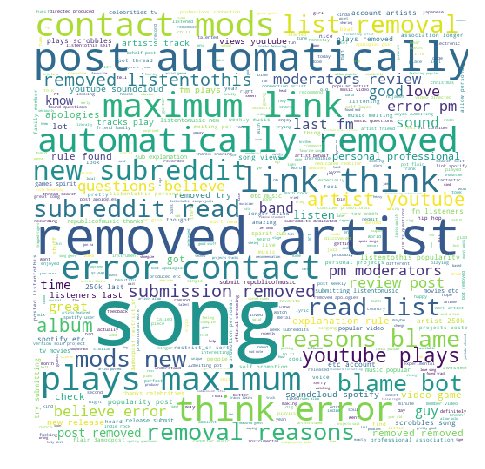

In [19]:
wc_text = ' '.join(commentDF['clean_sents'][-10000:].sum())
pos_wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(wc_text)
plt.figure(figsize=(16,8))
plt.imshow(pos_wc)
plt.axis("off")
#type(wc_text)

In [97]:
commentDF = commentDF[commentDF.author!="AutoModerator"]
smallDF = commentDF[(commentDF.created_utc > date_epoch(2014,2,1))&(commentDF.created_utc < date_epoch(2014,8,31))]
beforeDF = commentDF[(commentDF.created_utc > date_epoch(2014,2,1))&(commentDF.created_utc < date_epoch(2014,5,7))]
afterDF = commentDF[(commentDF.created_utc > date_epoch(2014,5,7))&(commentDF.created_utc < date_epoch(2014,8,31))]

(-0.5, 499.5, 499.5, -0.5)

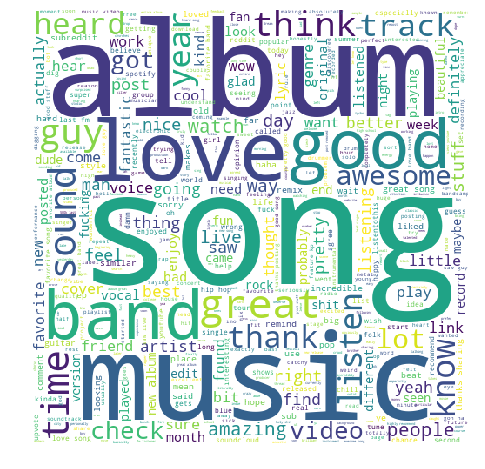

In [99]:
wc_text = ' '.join(beforeDF['clean_sents'].sum())
pos_wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(wc_text)
plt.figure(figsize=(16,8))
plt.imshow(pos_wc)
plt.axis("off")
#type(wc_text)

(-0.5, 499.5, 499.5, -0.5)

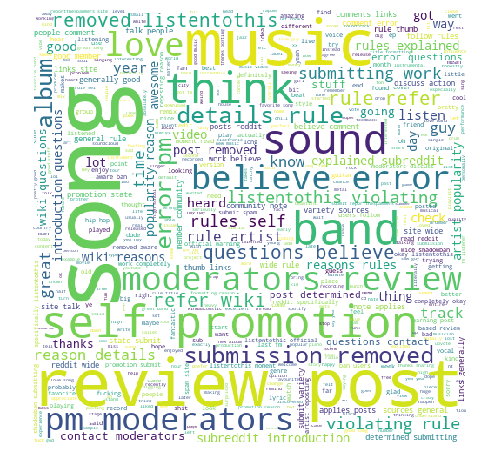

In [103]:
wc_text = ' '.join(afterDF['clean_sents'].sum())
pos_wc = wordcloud.WordCloud(background_color="white", max_words=500, width=1000, height=1000, mode='RGBA', scale=0.5).generate(wc_text)
plt.figure(figsize=(16,8))
plt.imshow(pos_wc)
plt.axis("off")

### Clustering with K-means

In [104]:
beforeDF['clean_text'] = beforeDF['clean_sents'].apply(' '.join)
# convert documents into word count vectorizer
CountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
commentVects = CountVectorizer.fit_transform(beforeDF['clean_text'])
# tf-idf
TFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(commentVects)
commentTF = TFTransformer.transform(commentVects)
# prune matrix of features
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
commentTFVects = TFVectorizer.fit_transform(beforeDF['clean_text'])

In [105]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(commentTFVects.toarray())
reduced_data = pca.transform(commentTFVects.toarray())
#reduced_data

In [106]:
'''
Find the optimal cluster number
'''
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


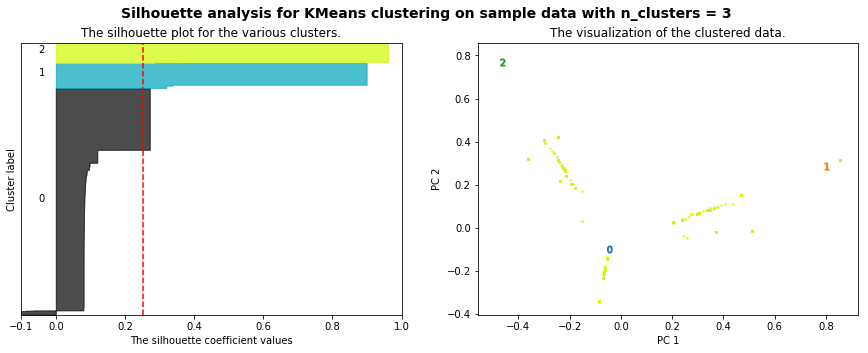

For n_clusters = 3, The average silhouette_score is : 0.253


In [186]:
X = commentTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


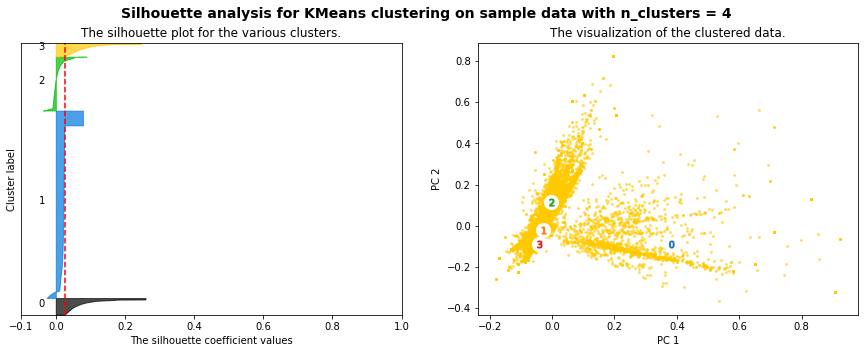

For n_clusters = 4, The average silhouette_score is : 0.026


In [108]:
X = commentTFVects.toarray()
plotSilhouette(4, X)

In [128]:
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


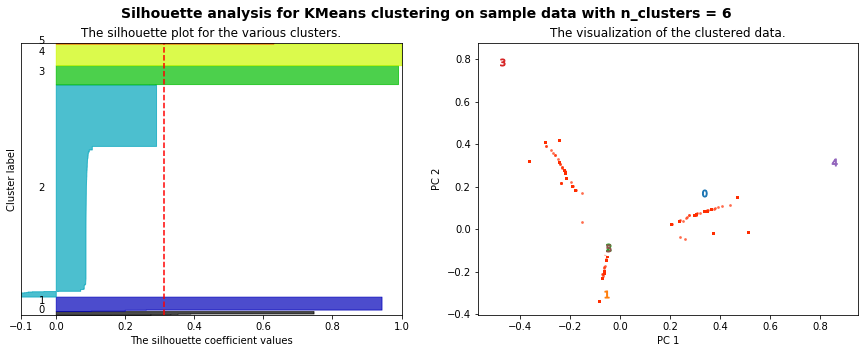

For n_clusters = 6, The average silhouette_score is : 0.313


In [185]:
plotSilhouette(6, X)

In [22]:
numClusters = 5
km = sklearn.cluster.KMeans(n_clusters=5, init='k-means++')
km.fit(commentTFVects)
commentDF['kmeans_predictions'] = km.labels_

In [23]:
comment_terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % comment_terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 like
 sounds
 song
 music
 sound
 feel
 good
 lot
 album
 check


Cluster 1:
 removed
 thanks
 video
 post
 like
 youtube
 try
 reason
 mods
 got


Cluster 2:
 post
 artist
 error
 removed
 reasons
 subreddit
 plays
 rule
 youtube
 removal


Cluster 3:
 song
 good
 album
 great
 music
 thanks
 band
 awesome
 know
 time


Cluster 4:
 love
 song
 album
 band
 music
 great
 guys
 thanks
 good
 like




### POS tagging

In [109]:
import spacy
nlp = spacy.load("en_core_web_sm")
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    final_string = ' '.join(sentences)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [111]:
beforeDF['POS_sents'] = beforeDF['clean_sents'].apply(lambda x: tag_sents_pos(x))
afterDF['POS_sents'] = afterDF['clean_sents'].apply(lambda x: tag_sents_pos(x))

In [70]:
smallDF['clean_sents'][-10:].apply(lambda x: tag_sents_pos(x))

123017    [[(dope, NNP), (bass, NNP), (lines, NNS), (nic...
123018     [[(sounds, VBZ), (progressive, JJ), (dope, NN)]]
123019    [[(oh, UH), (god, UH), (love, VBP), (alice, RB...
123020    [[(like, IN), (rhythm, NN), (vocals, VBZ), (ha...
123021    [[(digging, VBG), (kind, RB), (kept, VBD), (su...
123022    [[(ones, NNS), (responsible, JJ), (making, VBG...
123023    [[(goddamn, VB), (good, JJ), (like, IN), (seal...
123024    [[(hell, UH), (yeah, UH), (got, VBD), (great, ...
123025    [[(song, NNP), (grab, NNP)], [(1:04, CD), (hoo...
123026    [[(good, JJ), (man, NN), (relaxing, VBG), (soo...
Name: clean_sents, dtype: object

In [71]:
smallDF['POS_sents'] = smallDF['clean_sents'].apply(lambda x: tag_sents_pos(x))

In [127]:
countTarget = 'NN'
targetCounts = {}
for entry in beforeDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:150]

[('music', 1486),
 ('love', 1041),
 ('song', 960),
 ('band', 947),
 ('time', 793),
 ('stuff', 639),
 ('lot', 491),
 ('album', 487),
 ('video', 471),
 ('track', 433),
 ('year', 322),
 ('version', 295),
 ('way', 285),
 ('bit', 282),
 ('man', 282),
 ('sound', 278),
 ('work', 269),
 ('thing', 268),
 ('check', 257),
 ('rock', 244),
 ('artist', 234),
 ('voice', 224),
 ('day', 216),
 ('post', 196),
 ('pop', 190),
 ('couple', 169),
 ('listen', 165),
 ('night', 164),
 ('cover', 162),
 ('week', 161),
 ('youtube', 157),
 ('genre', 155),
 ('fan', 154),
 ('singer', 154),
 ('style', 154),
 ('link', 150),
 ('guitar', 149),
 ('metal', 148),
 ('watch', 145),
 ('guy', 141),
 ('life', 139),
 ('friend', 137),
 ('month', 126),
 ('shit', 125),
 ('today', 119),
 ('end', 118),
 ('place', 116),
 ('record', 116),
 ('summer', 112),
 ('folk', 112),
 ('tune', 112),
 ('chance', 110),
 ('jazz', 109),
 ('performance', 108),
 ('sub', 108),
 ('mind', 108),
 ('opinion', 105),
 ('release', 104),
 ('point', 103),
 ('page'

In [81]:
countTarget = 'JJ'
targetCounts = {}
for entry in smallDF['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:50]

[('good', 4930),
 ('great', 3477),
 ('new', 1967),
 ('listentothis', 1698),
 ('wide', 1684),
 ('favorite', 1496),
 ('amazing', 1255),
 ('live', 1159),
 ('awesome', 1094),
 ('little', 1078),
 ('subreddit', 1031),
 ('official', 1001),
 ('cool', 988),
 ('general', 904),
 ('aware', 901),
 ('wiki', 896),
 ('reddit', 867),
 ('determined', 861),
 ('different', 833),
 ('bad', 806),
 ('nice', 794),
 ('shadowban', 778),
 ('original', 708),
 ('big', 695),
 ('sure', 683),
 ('old', 673),
 ('similar', 592),
 ('right', 575),
 ('popular', 519),
 ('long', 479),
 ('incredible', 478),
 ('fantastic', 471),
 ('free', 439),
 ('interesting', 430),
 ('high', 427),
 ('beautiful', 426),
 ('glad', 423),
 ('black', 381),
 ('sound', 369),
 ('sorry', 364),
 ('real', 361),
 ('electronic', 359),
 ('entire', 357),
 ('worth', 349),
 ('single', 341),
 ('huge', 334),
 ('favourite', 325),
 ('wrong', 320),
 ('hard', 312),
 ('happy', 307)]

In [94]:
NTarget = 'NN'
Word = 'fantastic'
NResults = set()
for entry in smallDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'jazz', 'stuff', 'track', 'tomorrow', 'edit', 'youtube', 'orbit', 'art', 'energy', 'door', 'grape', 'person', 'verse', 'crew', 'lot', 'vii', 'cradle', 'thinker', 'hop', 'ipm', 'year', 'time', 'soundtrack', 'victory', 'way', 'love', 'treat', 'discography', 'rank', 'fire', 'venue', 'silence', 'work', 'fact', 'earth', 'imo', 'guy', 'team', 'house', 'yesterday', 'kexp', 'butch', 'soul', 'console', 'charge', 'list', 'trust', 'hq', 'song', 'consciousness', 'cycle', 'place', 'performance', 'spot', 'fucking', 'affair', 'act', 'poetry', 'remix', 'duality', 'summer', 'classic', 'singer', 'thing', 'fan', 'cover', 'weekend', 'ear', 'couple', 'cat', 'voice', 'beekeeper', 'band', 'ghost', 'pray', 'bloody', 'world', 'version', 'flock', 'album', 'man', 'shame', 'root', 'anarchy', 'lineage', 'music', 'attention', 'note', 'status', 'experiment', 'sky', 'sea', 'whoopdefuckindoo', 'bass', 'addition', 'recommendation', 'concert', 'combination', 'feckin', 'video', 'pot', 'movie', 'buildup', 'somebody', 're

In [92]:
NTarget = 'JJ'
Word = 'texture'
NResults = set()
for entry in smallDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'great', 'vocal', 'thick', 'fatten', 'unique', 'certain'}


In [123]:
NTarget = 'JJ'
Word = 'verse'
NResults = set()
for entry in beforeDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'2nd', 'stark', 'annoyed', 'second', 'feminine', 'creative', 'stupid', '3rd'}


In [93]:
NTarget = 'JJ'
Word = 'color'
NResults = set()
for entry in smallDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'bright', 'african', 'blue'}


In [122]:
NTarget = 'JJ'
Word = 'pace'
NResults = set()
for entry in afterDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'frantic', 'slow', 'single', 'frenetic', 'playlist', 'running', 'glacial', 'triple', 'usual', 'good'}


In [120]:
NTarget = 'JJ'
Word = 'tone'
NResults = set()
for entry in beforeDF['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults)     

{'wonderful', 'surprised', 'abrasive', 'lifeless', 'different', 'half', 'staccato', 'experimental', 'discordant', 'unique', 'similar', 'soft'}


In [4]:
'''
Creates a graph over a given period of time showing for users in a given subreddit, 
their average number of comments per month.
'''
raw_directory = '../Project/Data'
csv_directory = '../Project/Data/processed'
graph_directory = '../Project/Data/graphs/'
png_directory = '../Project/Data/pngs/'
#months = ['01', '03', '05', '07', '09', '11']

In [26]:
default_epoch = int(dt.datetime(2014, 5, 7).timestamp())
start_epoch = int(dt.datetime(2013, 5, 7).timestamp())
end_epoch = int(dt.datetime(2016, 5, 7).timestamp())
print("Default: ", default_epoch, start_epoch, end_epoch)
commentDF['before'] = (commentDF.created_utc < default_epoch)
#commentDF['before'][:10]
beforeDF = commentDF[commentDF.before==1]
afterDF = commentDF[commentDF.before==0]
print(min(commentDF.created_utc))

Default:  1399438800 1367902800 1462597200
1367903214


### Network

In [ ]:
'''
1. Figure out who the common users across the entire month are. This is to weed out one time users. 
We want users that have commented at least once in 2 separate months.

2. Create a dictionary of user to comments so dict[user][month number] returns #comments in that month

3. Average out the number of comments a month, so 12 averages

4. Plot this, x axis is number of months since commenting the first time, y axis is number of comments
'''

def create_month_to_users_dict(files):
    '''
    files should be 1,3,5,7,9,11 of a given year. files are csvs
    '''
    month_to_users_dict = {}
    for file in files:
        month_to_users_dict[file] = set()
        with open(file, newline = '') as f:
            reader = csv.reader(f)
            for line in reader:
                if not line or line[0] == '' or len(line) < 3 or '[deleted]' == line[2]:
                    continue
                user_node = line[2]
                month_to_users_dict[file].add(user_node)

    return month_to_users_dict


def find_recurring_users(month_to_users_dict):
    #month_to_users_dict is month to all the users in that dict for a single subreddit

    user_recurrence_count = defaultdict(int)
    for month in month_to_users_dict:
        for user in month_to_users_dict[month]:
            user_recurrence_count[user] += 1

    recurring_users = [x for x in user_recurrence_count if user_recurrence_count[x] >= 2]
    temp = [1,2,3,4,5,6]
    for i in temp:
        print(i)
        print(len([x for x in user_recurrence_count if user_recurrence_count[x] >= i]))

    return recurring_users


def find_comment_counts(users, graph_files, subreddit):
    #graph_files have to be in chronological order

    users_comment_counts = defaultdict(list)
    for graph_file in graph_files:
        graph = nx.read_gml(graph_file)
        for user in users:
            if graph.has_edge(subreddit, user):
                users_comment_counts[user].append(graph[subreddit][user]['weight']) #add weight to user's history
    return users_comment_counts         


def calculate_average_comments_per_month(users_comment_counts, png_file_name = None):
    '''
    we are interested in calculating the average #comments in the first month of a user joining 
    a subreddit, the second month, etc... Interested in seeing if as a user stays in a political 
    subreddit, if they comment more and more on average
    '''

    average_comment_count_month = []
    x_axis = [int(x) for x in months] #number of month

    for i in range(len(x_axis)):
        counter_users = 0
        total_comments = 0
        for user in users_comment_counts:
            try:
                total_comments += users_comment_counts[user][i]
                counter_users += 1
            except:
                continue
        if counter_users != 0:
            average_comment_count_month.append(total_comments / counter_users)
        # else:
        #   average_comment_count_month.append(0)
    return average_comment_count_month

    # plt.plot(x_axis, average_comment_count_month)
    # plt.xlabel('Months Active')
    # plt.ylabel('Average Number of Comments Per User')
    # plt.title('Average Number of Comments Per User vs. Months Active')
    # #plt.show()
    # plt.savefig(png_file_name)

def plot_all_lines(comment_counts_dict, png_file):
    x_axis = [int(x) for x in months]
    for subreddit in comment_counts_dict:
        print(subreddit)
        y_axis = comment_counts_dict[subreddit]
        print(x_axis)
        print(y_axis)
        len_y_axis = len(y_axis)
        plt.plot(x_axis[:len_y_axis], y_axis, label = subreddit)
    plt.xlabel('Months Active')
    plt.ylabel('Average Number of Comments Per User')
    plt.title('Average Number of Comments Per User vs. Months Active')
    plt.legend()
    plt.savefig(png_file)


def main():
    # try:
    #   subreddit = sys.argv[1]
    #   year = sys.argv[2]
    # except Exception as e:
    #   print(e)
    #   print('Please enter a year and a subreddit.')
    #   return
    year = sys.argv[1]
    subreddits = ['Conservative', 'The_Donald', 'Republican', 'AskTrumpSupporters', 'politics']
    #subreddits = ['AskTrumpSupporters']
    subreddits_to_files_dict = {}
    for subreddit in subreddits:
        csv_files = []
        graph_files = []
        relevant_months = months
        for month in relevant_months:
            csv_file = csv_directory + 'RC_' + year + '-' + month + '.bz2_csv_' + subreddit + '.csv'
            csv_files.append(csv_file)
            graph_file = graph_directory + year + '-' + month + '_bipartite.gml'
            graph_files.append(graph_file)

        subreddits_to_files_dict[subreddit] = [csv_files, graph_files]

    comment_counts_dict = {}
    for subreddit in subreddits_to_files_dict:
        print(subreddit)
        csv_files = subreddits_to_files_dict[subreddit][0]
        graph_files = subreddits_to_files_dict[subreddit][1]
        month_to_users = create_month_to_users_dict(csv_files)
        recurring_users = find_recurring_users(month_to_users)
        comment_counts = find_comment_counts(recurring_users, graph_files, subreddit)
        comment_counts_dict[subreddit] = calculate_average_comments_per_month(comment_counts)

    png_file = png_directory +  'all_subreddits_' + year + '_user_comments_3.png'

    plot_all_lines(comment_counts_dict, png_file)

if __name__ == "__main__":
    main()